In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math, random

# Convolution and Linear Systems, Again

Notes for DSP Oppenheim and Winsky Ch2, Linear Time-Invariant Systems are in Week1 notebook. Instead, below I'll maually implement convolution for two generic signals. Subsequently, I'll list and demo the top 10 types of impulse responses. 

Remember, the convolution formula is:

$$y[n] = \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k] $$

OR, if working with matrices (as I found out today):

$$ y[n] = \sum_{k=-\infty}^{\infty} h[k]\cdot x[n-k] $$

For $x[n]$ of length $N$ and $h[m]$ of length $M$, the convolved form $y[n]$ is of length $N+M-1$. Modify the bounds of $k$ to range from $k\in[0,N)$ aka $0$ to $N-1$. But not every $k$ in that range is valid, as $h[n-k]$ also needs to be valid. Thus it can be written:

Lower bound: $k=\max(0,n-(M-1))$

Upper bound: $k=\min(n,N-1)$

In [5]:
# Manual Convolution:

x = np.array([1,2,3])
h = np.array([0.5,1])

n_x = np.arange(len(x))
n_h = np.arange(len(h))

N = len(x)
M = len(h)
y = []

for n in range(N + M - 1):
    response = 0
    for k in range(M):
        if 0 <= n - k < N:
            response += x[n - k] * h[k]
    y.append(response)
    
'''
OR
for n in range(N + M - 1):
    response = 0
    k_min = max(0, n - (M - 1))
    k_max = min(n, N - 1)
    for k in range(k_min, k_max + 1):
        response += x[k] * h[n - k]
    y.append(response)
'''

y = np.array(y)

n_y = np.arange(len(y))

<StemContainer object of 3 artists>

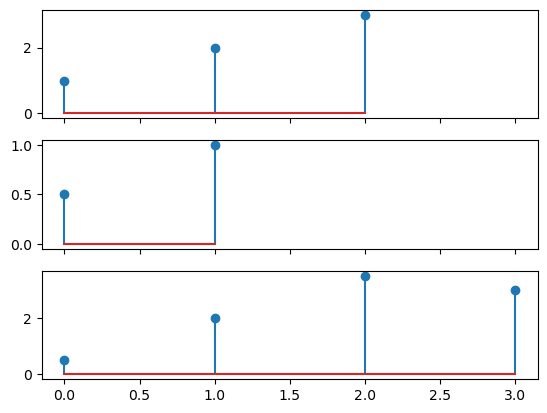

In [8]:
fig, ax = plt.subplots(3,1,sharex=True)

ax[0].stem(n_x,x)
ax[1].stem(n_h,h)
ax[2].stem(n_y,y)

[0.5 1.  0.  0. ]
[0. 0. 0.]
[0.5 0.  0. ]
[[0.5 0.  0. ]
 [1.  0.5 0. ]
 [0.  1.  0.5]
 [0.  0.  1. ]]
[0.5 2.  3.5 3. ]


<StemContainer object of 3 artists>

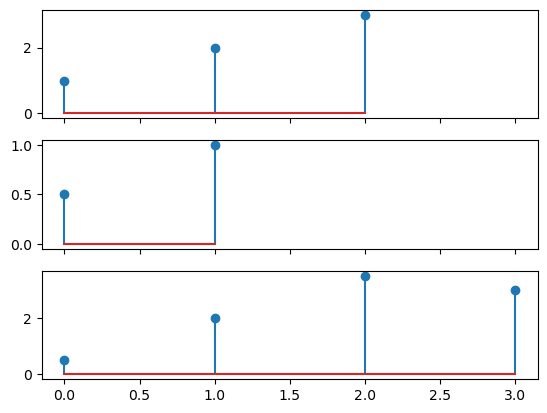

In [15]:
# Convolution via matrices!

from scipy.linalg import toeplitz

# I need the first column and row
first_col = np.concatenate([h, np.zeros(N - 1)])
print(first_col)
first_row = np.zeros(N)
print(first_row)
first_row[0] = h[0]
print(first_row)

H = toeplitz(first_col, first_row)  # Toeplitz convolution matrix
print(H)

z = H @ x  # Convolution via matrix multiplication
print(z)
n_z = np.arange(len(y))

fig, ax = plt.subplots(3,1,sharex=True)

ax[0].stem(n_x,x)
ax[1].stem(n_h,h)
ax[2].stem(n_z,z)

## Most common impulse responses

1. Ideal Low pass filter via sinc
    - Frequency filtering, non-wondowed sinc
2. Unit delay
    - Modeling simple delay systems
3. Exponential decay
    - Modeling causal 1st order IIRs: physical systems with memory/decay
4. Moving average (boxcar)
    - FIR smoothing filters
5. FIR
    - Windowed sinc, Kaiser, LPF, HPF, BPF
6. IIR
    - Recursive systems, Butterworth, Chebyshev
7. Gaussian impulse response
    - Minimally distorting filtering
8. Bandpass filter
    - Emphasizes a certain frequency band
9. Echo / Multipath response
    - Audio echo, **radar**, channel responses
10. Impulse train
    - Sampling theory, periodic systems
    
I have written Python examples for each of the aforementioned impulses. Nothing crazy, just a barebones example.

(0.0, 0.15)

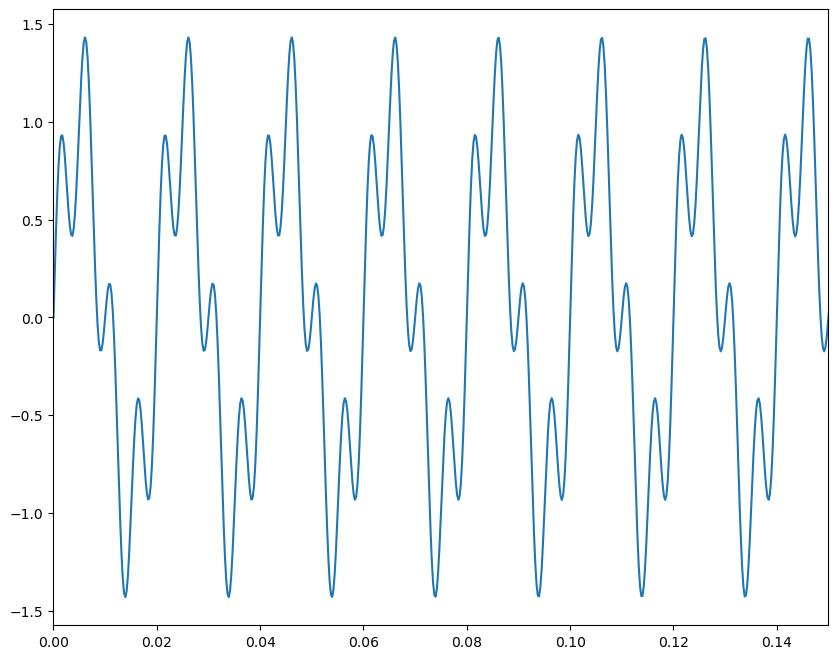

In [18]:
# Sample waveform for 1, 2, 4, 5, 7

fs = 4096
f1, f2 = 50, 200 # Hz
duration = 1 # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
x = np.sin(2*np.pi*f1*t) + 0.5*np.sin(2*np.pi*f2*t)

plt.figure(figsize=(10,8))
plt.plot(t,x)
plt.xlim(0,0.15)

(0.0, 0.15)

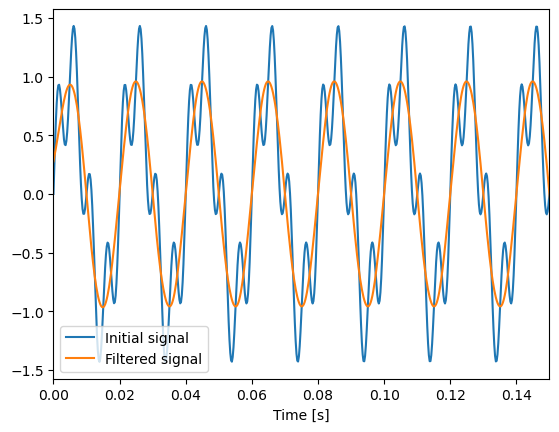

In [19]:
'''
Ideal low-pass filter

Uses sinc aka sin(pi*x)/pi*x

From numpy docs:

The sinc function is used in various signal processing applications, 
including in anti-aliasing, in the construction of a Lanczos resampling filter, 
and in interpolation.

For bandlimited interpolation of discrete-time signals, the ideal interpolation kernel is 
proportional to the sinc function.
'''
f_c = 100 # Hz, cutoff the high frequency component

# Remember this filter takes SAMPLES in as input, not seconds, wrong units!, so convert to samples first for
# consistency's sake, aka t = n/f_s because I want to act on x[n], not x(t)

n = np.arange(-100,101) # filter length is 101 by convention, see tables below
idealLPF = 2 * f_c * np.sinc(2 * f_c * n / fs) / np.sum(2 * f_c * np.sinc(2 * f_c * n / fs))

y = np.convolve(x,idealLPF, mode='same')

plt.plot(t,x,label='Initial signal')
plt.plot(t,y,label='Filtered signal')
plt.xlabel('Time [s]')
plt.legend()
plt.xlim(0,0.15)

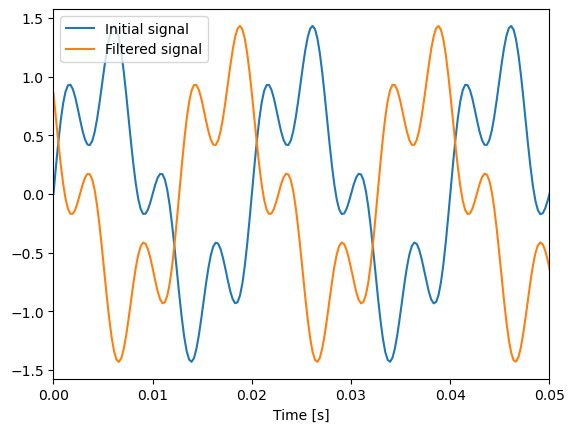

In [4]:
'''
Unit delay

'''
def impulse(n0, A=1.0, N=101):
    """
    Discrete-time unit impulse: A·delta[n - n0] over length-N vector
    n0: index at which to place the impulse (must be integer)
    A: amplitude
    N: total length
    """
    imp = np.zeros(N)
    if 0 <= n0 < N:
        imp[n0] = A
    return imp

impulseResponse = impulse(20)

y = np.convolve(x,impulseResponse,mode='same')

plt.plot(t,x,label='Initial signal')
plt.plot(t,y,label='Filtered signal')
plt.xlabel('Time [s]')
plt.xlim(0,0.05)
plt.legend()

### Conventions for choosing filter length

| Factor                      | Impact                                                   |
| --------------------------- | -------------------------------------------------------- |
| **Cutoff frequency** $f_c$  | Lower $f_c$ → longer sinc tails → need more samples      |
| **Transition width**        | Narrower transition → longer filter                      |
| **Stopband attenuation**    | More attenuation (steeper drop-off) → longer filter      |
| **Application constraints** | Real-time filtering or embedded systems may limit length |
| **Window type**             | Some windows achieve better roll-off with fewer taps     |



| Use Case                  | Typical Filter Length |
| ------------------------- | --------------------- |
| General-purpose filtering | 51 to 201 taps        |
| Audio or sharp LPF        | 301–801 taps          |
| Embedded real-time DSP    | ≤ 64 taps             |
| Adaptive filters          | Often ≤ 32 taps       |

| Symbol | Meaning                                     | Typical Range            |
| ------ | ------------------------------------------- | ------------------------ |
| $N$    | Number of samples in your **signal** $x[n]$ | Often thousands or more  |
| $L$    | Number of samples in your **filter** $h[n]$ | Usually tens to hundreds |

| Property   | Typical Relationship     |
| ---------- | ------------------------ |
| $L$ vs $N$ | $L \ll N$ is common      |
| Use of $L$ | Defines filter sharpness |
| Use of $N$ | Defines signal duration  |


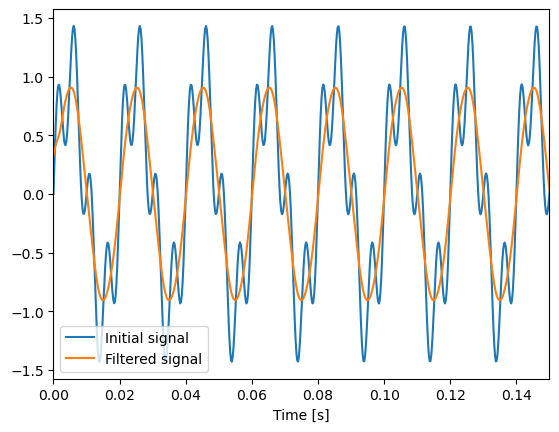

In [11]:
'''
Moving average (Boxcar)

'''
def boxcar(L):
    return np.ones(L)/L

boxcar = boxcar(20)
y = np.convolve(x,boxcar,mode='same')

plt.plot(t,x,label='Initial signal')
plt.plot(t,y,label='Filtered signal')
plt.xlabel('Time [s]')
plt.xlim(0,0.15)
plt.legend()

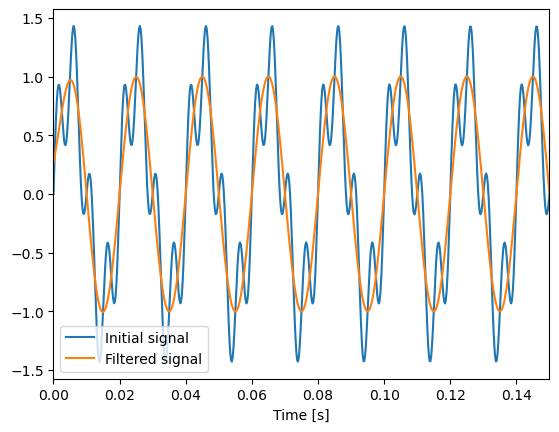

In [17]:
'''
Kaiser FIR

'''
from scipy.signal import firwin, freqz, kaiserord

width = 50      # Transition width (Hz)
ripple_db = 60  # Stopband attenuation

# Compute optimal order and beta for desired ripple and transition width
N, beta = kaiserord(ripple_db, width / fs)
N |= 1  # Make sure filter length is odd

# Design the filter
kaiser = firwin(N, cutoff=f_c, window=('kaiser', beta), fs=fs)

y = np.convolve(x,kaiser,mode='same')

plt.plot(t,x,label='Initial signal')
plt.plot(t,y,label='Filtered signal')
plt.xlabel('Time [s]')
plt.xlim(0,0.15)
plt.legend()